In [9]:
import datetime
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Model
from tensorflow.python.keras._impl.keras.layers import Input
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import (Dense, Flatten)
from tensorflow.python.keras.optimizers import Adam
from skimage.color import gray2rgb


% matplotlib inline
from tensorflow.python.keras.utils import to_categorical


In [10]:
BATCH_SIZE = 256
EPOCHS = 27
PATIENCE = 50
LEARNING_RATE = 0.001
now = str(datetime.datetime.now())
CHECKPOINT_NAME = '_'.join(('checkpoint ' + now).split(' '))
print(CHECKPOINT_NAME)


checkpoint_2018-03-21_09:56:34.680821


Read data and add it to a csv

In [11]:
def load_data(test=False, mode=0, rgb=False):
    files = ['fer2013/training.csv',
             'fer2013/publictest.csv',
             'fer2013/privatetest.csv']

    data = pd.read_csv(files[mode])

    data['pixels'] = data['pixels'].apply(lambda img: np.fromstring(img, sep=' '))
    X = np.vstack(data['pixels'].values)
    # #normalize data
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    if rgb:  # transform data cu rgb if needed
        X = gray2rgb(X)
        X = X.reshape(-1, 48, 48, 3)
    else:
        X = X.reshape(-1, 48, 48, 1)

    print(X.shape)

    if not test:
        y = data['emotion'].values
        y = y.astype(np.int)
        y = to_categorical(y)
    else:
        y = None

    return X, y


In [12]:
checkpointer = ModelCheckpoint(filepath='checkpoints/{0}.h5'.format(CHECKPOINT_NAME), verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_images=True)

model_callbacks = [checkpointer, early_stop, tensorboard]


In [13]:
model_vgg16_conv = VGG16(include_top=False)

input = Input(shape=(48, 48, 3), name='image_input')

# Use the generated model
output_vgg16_conv = model_vgg16_conv(input)

# Add the fully-connected layers
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(7, activation='softmax', name='predictions')(x)

# Create your own model
model = Model(inputs=input, outputs=x)
model.summary()

optimizer = Adam(lr=0.0001, decay=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              2101248   
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 7)                 28679     
Total params: 33,625,927
Trainable params: 33,625,927
Non-trainable params: 0
________________________________________________________________

In [14]:
X, y = load_data(mode=0, rgb=True)
X_validation, y_validation = load_data(mode=1, rgb=True)
hist = model.fit(X, y, shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 callbacks=model_callbacks, verbose=1,
                 validation_data=(X_validation, y_validation))


(28709, 48, 48, 3)
(3589, 48, 48, 3)
Train on 28709 samples, validate on 3589 samples
Epoch 1/27
28709/28709 [==============================] - 457s - loss: 1.4399 - acc: 0.4418 - val_loss: 1.2750 - val_acc: 0.5107
Epoch 2/27
28709/28709 [==============================] - 458s - loss: 1.1397 - acc: 0.5673 - val_loss: 1.1099 - val_acc: 0.5715
Epoch 3/27
28709/28709 [==============================] - 644s - loss: 1.0070 - acc: 0.6233 - val_loss: 1.0522 - val_acc: 0.6149
Epoch 4/27
28709/28709 [==============================] - 801s - loss: 0.8880 - acc: 0.6695 - val_loss: 1.0777 - val_acc: 0.6102
Epoch 5/27
28709/28709 [==============================] - 779s - loss: 0.7576 - acc: 0.7235 - val_loss: 1.0873 - val_acc: 0.6119
Epoch 6/27
28709/28709 [==============================] - 453s - loss: 0.6228 - acc: 0.7751 - val_loss: 1.2295 - val_acc: 0.5904
Epoch 7/27
28709/28709 [==============================] - 453s - loss: 0.4952 - acc: 0.8241 - val_loss: 1.2289 - val_acc: 0.6166
Epoch 8/27


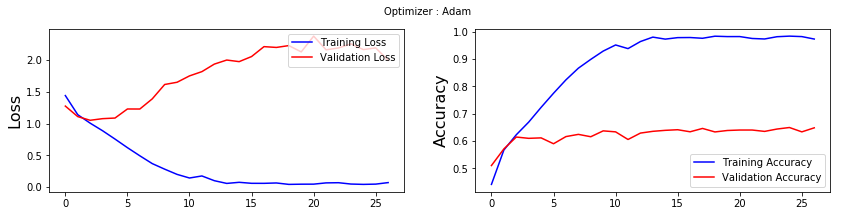

In [15]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [16]:
x_eval, y_eval = load_data(mode=2, rgb=True)

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)
model.save_weights('models/{0}.h5'.format(CHECKPOINT_NAME))


(3589, 48, 48, 3)
3589/3589 [==============================] - 19s    
Score :  1.94920190665
Accuracy :  65.0877681822


In [17]:
model.load_weights('checkpoints/{0}.h5'.format(CHECKPOINT_NAME))

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)


3589/3589 [==============================] - 20s    
Score :  1.00713410501
Accuracy :  62.6636946258
